In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

In [14]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]

# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]


# Placeholders
# 'None' means TensorFlow shouldn't expect a fixed number in that dimension
X = tf.placeholder(tf.float32, [None, numFeatures]) # Iris has 4 features, so X is a tensor to hold our data.
yGold = tf.placeholder(tf.float32, [None, numLabels]) # This will be our correct answers matrix for 3 classes.

In [21]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

In [22]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=0.01,
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=0.01,
                                    name="bias"))

In [35]:
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

In [36]:
# Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [37]:
#Defining our cost function - Squared Mean Error
cost_OP = tf.nn.l2_loss(activation_OP - yGold, name="squared_error_cost")

#Defining our Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

In [38]:
activation_OP

<tf.Tensor 'activation:0' shape=(?, 3) dtype=float32>

In [39]:
# Create a tensorflow session
sess = tf.Session()

# Initialize our weights and biases variables.
init_OP = tf.global_variables_initializer()

# Initialize all tensorflow variables
sess.run(init_OP)

In [40]:
# argmax(activation_OP, 1) returns the label with the most probability
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# If every false prediction is 0 and every true prediction is 1, the average returns us the accuracy
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# Merge all summaries
merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP, weightSummary, biasSummary])

# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

In [41]:
# Initialize reporting variables
cost = 0
diff = 1
epoch_values = []
accuracy_values = []
cost_values = []

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], feed_dict={X: trainX, yGold: trainY})
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g, cost %g, change in cost %g"%(i, train_accuracy, newCost, diff))


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.333333, cost 33.9598, change in cost 33.9598
step 10, training accuracy 0.606061, cost 30.0099, change in cost 3.94996
step 20, training accuracy 0.646465, cost 28.0715, change in cost 1.93839
step 30, training accuracy 0.646465, cost 26.4393, change in cost 1.63216
step 40, training accuracy 0.646465, cost 25.0852, change in cost 1.35408
step 50, training accuracy 0.646465, cost 23.9674, change in cost 1.11786
step 60, training accuracy 0.646465, cost 23.0423, change in cost 0.925114
step 70, training accuracy 0.646465, cost 22.2715, change in cost 0.770781
step 80, training accuracy 0.646465, cost 21.6235, change in cost 0.648016
step 90, training accuracy 0.646465, cost 21.0732, change in cost 0.550255
step 100, training accuracy 0.656566, cost 20.6012, change in cost 0.472008
step 110, training accuracy 0.666667, cost 20.1923, change in cost 0.408924
step 120, training accuracy 0.666667, cost 19.8346, change in cost 0.357639
step 130, training accuracy 0

C:\Users\user1\.conda\envs\tensorflow_env\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user1\.conda\envs\tensorflow_env\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


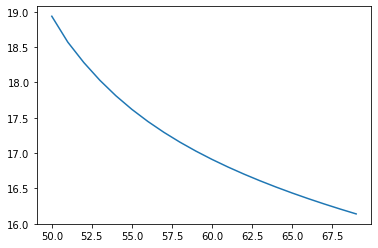

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(cost_values[i-50:i]) for i in range(len(cost_values))])
plt.show()

In [43]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [44]:
def apply_to_list(some_list, f):    
    return [f(x) for x in some_list]
ints = [4, 0, 1, 5, 6] 
apply_to_list(ints, lambda x: x * 2) 

[8, 0, 2, 10, 12]